Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [97]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function

import time

from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [98]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']

  del save  # hint to help gc free up memory
    
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [99]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [100]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

#### 1-Hidden NN, SGD, without L2 Regularization, without Dropout, all batch

Initialized
Minibatch loss at step 0: 423.479553
Minibatch accuracy: 3.9%
Validation accuracy: 26.8%
Minibatch loss at step 500: 29.257612
Minibatch accuracy: 79.7%
Validation accuracy: 76.0%
Minibatch loss at step 1000: 15.952819
Minibatch accuracy: 74.2%
Validation accuracy: 80.6%
Minibatch loss at step 1500: 4.361738
Minibatch accuracy: 89.8%
Validation accuracy: 79.9%
Minibatch loss at step 2000: 3.716847
Minibatch accuracy: 84.4%
Validation accuracy: 81.4%
Minibatch loss at step 2500: 4.470253
Minibatch accuracy: 83.6%
Validation accuracy: 81.4%
Minibatch loss at step 3000: 2.139399
Minibatch accuracy: 86.7%
Validation accuracy: 82.2%
Test accuracy: 89.1%

running_time 73.9540710449  sec


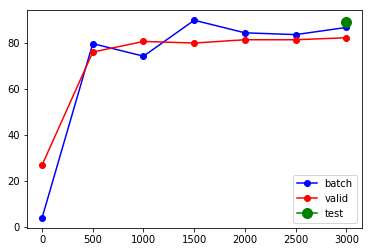

In [88]:
# ----------- Graph -------------
batch_size = 128

l2_coef = 0.0

num_node_h1 = 1014


# https://www.tensorflow.org/get_started/mnist/pros
keep_prob = 1.0

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_h1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_node_h1])
  )
  biases_h1 = tf.Variable(tf.zeros([num_node_h1]))
  output_h1 = tf.nn.dropout(
      tf.nn.relu(tf.matmul(tf_train_dataset, weights_h1) + biases_h1),
      keep_prob
  )

  weights = tf.Variable(
    tf.truncated_normal([num_node_h1, num_labels])
  )
  biases = tf.Variable(tf.zeros([num_labels]))
  logits = tf.matmul(output_h1, weights) + biases
    
  # Training computation.
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
  ) + l2_coef * (
      tf.nn.l2_loss(weights_h1) + tf.nn.l2_loss(weights)
  )
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.dropout(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_h1) + biases_h1), 1.0), 
        weights
    ) + biases
  )
  test_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_dataset, weights_h1) + biases_h1), 1.0), 
        weights
    ) + biases
  )
    
    

# ----------- Session -------------    
start_time = time.time()

steps = []
batch_accus = []
valid_accus = []

test_steps = []
test_accus = []

num_steps = 3001


# restrict training data to small batches
# batch_count = 3


with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized. 
    # So samples in each batch is equalivently randomly selected.
    # Note: we could use better randomization across epochs.
    
    
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
#     offset = (step * batch_size) % (batch_count * batch_size)

    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], 
      feed_dict=feed_dict
    )
    
    if (step % 500 == 0):
        steps.append(step)
        
        batch_accu = accuracy(predictions, batch_labels)
        batch_accus.append(batch_accu)        
        valid_accu = accuracy(valid_prediction.eval(), valid_labels)        
        valid_accus.append(valid_accu)
        
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % batch_accu)
        print("Validation accuracy: %.1f%%" % valid_accu)

  test_steps.append(step)
  test_accu = accuracy(test_prediction.eval(), test_labels)
  test_accus.append(test_accu)
  print("Test accuracy: %.1f%%" % test_accu)
    
print('\nrunning_time', time.time() - start_time, ' sec')

plt.figure()
plt.plot(steps, batch_accus, '-ob', label='batch')
plt.plot(steps, valid_accus, '-or', label='valid')
plt.plot(test_steps, test_accus, '-og', markersize=10, label='test')
plt.legend()
plt.show()    

---
Problem 1: L2 Regularization
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [73]:
w_arr = np.array([[1.0, 2.0] ,[3.0, 4.0]])
print(w_arr)
print( np.sum((w_arr * w_arr)) / 2 ) # element wise multiply

w = tf.constant(w_arr, dtype=tf.float32)
print(w)

l2 = tf.nn.l2_loss(w)
print(l2)

with tf.Session() as session:
    print(w.eval())
    print(l2.eval())

[[ 1.  2.]
 [ 3.  4.]]
15.0
Tensor("Const_6:0", shape=(2, 2), dtype=float32)
Tensor("L2Loss_7:0", shape=(), dtype=float32)
[[ 1.  2.]
 [ 3.  4.]]
15.0
[[ 2.  4.]
 [ 0.  8.]]


In [64]:
w1_arr = np.array([[1.0, 2.0] ,[3.0, 4.0]])
print(w1_arr)
print( np.sum((w1_arr * w1_arr)) ) # element wise multiply

w2_arr = np.array([[5.0, 6.0] ,[7.0, 8.0]])
print(w2_arr)
print( np.sum((w2_arr * w2_arr)) ) # element wise multiply

w1 = tf.constant(w1_arr, dtype=tf.float32)
print(w1)

w2 = tf.constant(w2_arr, dtype=tf.float32)
print(w2)

w_test = w1 + w2
print(w_test)

l2 = tf.nn.l2_loss(w1 + w2)
print(l2)

# this way is correct
l2_2 = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)
print(l2_2)

with tf.Session() as session:
    print(w1.eval())
    print(w2.eval())    
    print(w_test.eval())        
    print(l2.eval())
    print(l2_2.eval())    

[[ 1.  2.]
 [ 3.  4.]]
30.0
[[ 5.  6.]
 [ 7.  8.]]
174.0
Tensor("Const_1:0", shape=(2, 2), dtype=float32)
Tensor("Const_2:0", shape=(2, 2), dtype=float32)
Tensor("add:0", shape=(2, 2), dtype=float32)
Tensor("L2Loss_1:0", shape=(), dtype=float32)
Tensor("add_2:0", shape=(), dtype=float32)
[[ 1.  2.]
 [ 3.  4.]]
[[ 5.  6.]
 [ 7.  8.]]
[[  6.   8.]
 [ 10.  12.]]
172.0
102.0


#### Logistic Regression, SGD, with L2 Regularization

Initialized
Minibatch loss at step 0: 21.295424
Minibatch accuracy: 15.6%
Validation accuracy: 13.7%
Minibatch loss at step 500: 2.640944
Minibatch accuracy: 78.9%
Validation accuracy: 76.2%
Minibatch loss at step 1000: 1.786531
Minibatch accuracy: 78.1%
Validation accuracy: 78.3%
Minibatch loss at step 1500: 0.930337
Minibatch accuracy: 85.2%
Validation accuracy: 79.8%
Minibatch loss at step 2000: 0.857694
Minibatch accuracy: 87.5%
Validation accuracy: 80.7%
Minibatch loss at step 2500: 0.815475
Minibatch accuracy: 80.5%
Validation accuracy: 81.2%
Minibatch loss at step 3000: 0.788556
Minibatch accuracy: 82.0%
Validation accuracy: 81.9%
Test accuracy: 89.0%

running_time 4.05257701874  sec


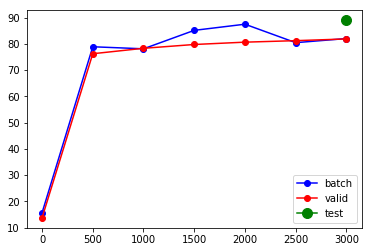

In [65]:
# ----------- Graph -------------
batch_size = 128

l2_coef = 0.001

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels])
  )
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
  ) + l2_coef * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
    
    
    
    
# ----------- Session -------------    
start_time = time.time()

steps = []
batch_accus = []
valid_accus = []

test_steps = []
test_accus = []

num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized. 
    # So samples in each batch is equalivently randomly selected.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # print('step', step, 'offset', offset, offset + batch_size -1)    
    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], 
      feed_dict=feed_dict
    )
    if (step % 500 == 0):
        steps.append(step)
        
        batch_accu = accuracy(predictions, batch_labels)
        batch_accus.append(batch_accu)        
        valid_accu = accuracy(valid_prediction.eval(), valid_labels)        
        valid_accus.append(valid_accu)
        
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % batch_accu)
        print("Validation accuracy: %.1f%%" % valid_accu)

  test_steps.append(step)
  test_accu = accuracy(test_prediction.eval(), test_labels)
  test_accus.append(test_accu)
  print("Test accuracy: %.1f%%" % test_accu)

print('\nrunning_time', time.time() - start_time, ' sec')

plt.figure()
plt.plot(steps, batch_accus, '-ob', label='batch')
plt.plot(steps, valid_accus, '-or', label='valid')
plt.plot(test_steps, test_accus, '-og', markersize=10, label='test')
plt.legend()
plt.show()


#### 1-Hidden NN, SGD, with L2 Regularization

Initialized
Minibatch loss at step 0: 662.922241
Minibatch accuracy: 5.5%
Validation accuracy: 27.8%
Minibatch loss at step 500: 199.122604
Minibatch accuracy: 79.7%
Validation accuracy: 80.3%
Minibatch loss at step 1000: 114.109039
Minibatch accuracy: 79.7%
Validation accuracy: 81.4%
Minibatch loss at step 1500: 67.721382
Minibatch accuracy: 88.3%
Validation accuracy: 83.2%
Minibatch loss at step 2000: 40.892807
Minibatch accuracy: 89.1%
Validation accuracy: 85.1%
Minibatch loss at step 2500: 24.871023
Minibatch accuracy: 89.8%
Validation accuracy: 86.0%
Minibatch loss at step 3000: 15.291300
Minibatch accuracy: 88.3%
Validation accuracy: 86.9%
Test accuracy: 93.1%

running_time 67.5627999306  sec


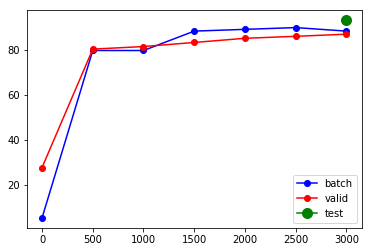

In [66]:
# ----------- Graph -------------
batch_size = 128

l2_coef = 0.001

num_node_h1 = 1014

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_h1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_node_h1])
  )
  biases_h1 = tf.Variable(tf.zeros([num_node_h1]))
        
  weights = tf.Variable(
    tf.truncated_normal([num_node_h1, num_labels])
  )
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  output_h1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_h1) + biases_h1)
    
  logits = tf.matmul(output_h1, weights) + biases

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
  ) + l2_coef * (
      tf.nn.l2_loss(weights_h1) + tf.nn.l2_loss(weights)
  )
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.relu(tf.matmul(tf_valid_dataset, weights_h1) + biases_h1),
        weights
    ) + biases
  )
  test_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.relu(tf.matmul(tf_test_dataset, weights_h1) + biases_h1),
        weights
    ) + biases
  )
    
    
    
# ----------- Session -------------    
start_time = time.time()

steps = []
batch_accus = []
valid_accus = []

test_steps = []
test_accus = []

num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized. 
    # So samples in each batch is equalivently randomly selected.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], 
      feed_dict=feed_dict
    )
    
    if (step % 500 == 0):
        steps.append(step)
        
        batch_accu = accuracy(predictions, batch_labels)
        batch_accus.append(batch_accu)        
        valid_accu = accuracy(valid_prediction.eval(), valid_labels)        
        valid_accus.append(valid_accu)
        
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % batch_accu)
        print("Validation accuracy: %.1f%%" % valid_accu)

  test_steps.append(step)
  test_accu = accuracy(test_prediction.eval(), test_labels)
  test_accus.append(test_accu)
  print("Test accuracy: %.1f%%" % test_accu)
        
print('\nrunning_time', time.time() - start_time, ' sec')

plt.figure()
plt.plot(steps, batch_accus, '-ob', label='batch')
plt.plot(steps, valid_accus, '-or', label='valid')
plt.plot(test_steps, test_accus, '-og', markersize=10, label='test')
plt.legend()
plt.show()    

---
Problem 2: Overfitting
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

#### 1-Hidden NN, SGD, without L2 Regularization, 3 batch

Initialized
Minibatch loss at step 0: 424.867645
Minibatch accuracy: 9.4%
Validation accuracy: 32.0%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 75.4%
Minibatch loss at step 1000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 75.4%
Minibatch loss at step 1500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 75.4%
Minibatch loss at step 2000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 75.4%
Minibatch loss at step 2500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 75.4%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 75.4%
Test accuracy: 82.7%

running_time 61.6764390469  sec


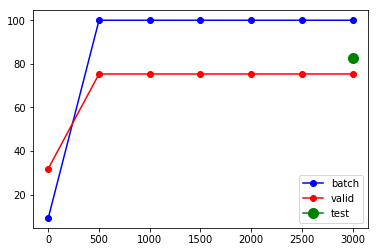

In [67]:
# ----------- Graph -------------

batch_size = 128

l2_coef = 0.0

num_node_h1 = 1014

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_h1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_node_h1])
  )
  biases_h1 = tf.Variable(tf.zeros([num_node_h1]))
        
  weights = tf.Variable(
    tf.truncated_normal([num_node_h1, num_labels])
  )
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  output_h1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_h1) + biases_h1)
    
  logits = tf.matmul(output_h1, weights) + biases

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
  ) + l2_coef * (
      tf.nn.l2_loss(weights_h1) + tf.nn.l2_loss(weights)
  )
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.relu(tf.matmul(tf_valid_dataset, weights_h1) + biases_h1),
        weights
    ) + biases
  )
  test_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.relu(tf.matmul(tf_test_dataset, weights_h1) + biases_h1),
        weights
    ) + biases
  )




# ----------- Session -------------
start_time = time.time()

steps = []
batch_accus = []
valid_accus = []

test_steps = []
test_accus = []

num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized. 
    # So samples in each batch is equalivently randomly selected.
    # Note: we could use better randomization across epochs.
    
#     offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # restrict training data to small batches
    offset = (step * batch_size) % (3 * batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], 
      feed_dict=feed_dict
    )
    
    if (step % 500 == 0):
        steps.append(step)
        
        batch_accu = accuracy(predictions, batch_labels)
        batch_accus.append(batch_accu)        
        valid_accu = accuracy(valid_prediction.eval(), valid_labels)        
        valid_accus.append(valid_accu)
        
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % batch_accu)
        print("Validation accuracy: %.1f%%" % valid_accu)

  test_steps.append(step)
  test_accu = accuracy(test_prediction.eval(), test_labels)
  test_accus.append(test_accu)
  print("Test accuracy: %.1f%%" % test_accu)
    
print('\nrunning_time', time.time() - start_time, ' sec')

plt.figure()
plt.plot(steps, batch_accus, '-ob', label='batch')
plt.plot(steps, valid_accus, '-or', label='valid')
plt.plot(test_steps, test_accus, '-og', markersize=10, label='test')
plt.legend()
plt.show()

#### 1-Hidden NN, SGD, L2 Regularization, 3 batch

Initialized
Minibatch loss at step 0: 31561.357422
Minibatch accuracy: 11.7%
Validation accuracy: 32.6%
Minibatch loss at step 500: 1.123118
Minibatch accuracy: 95.3%
Validation accuracy: 74.7%
Minibatch loss at step 1000: 1.273271
Minibatch accuracy: 89.1%
Validation accuracy: 77.3%
Minibatch loss at step 1500: 1.388651
Minibatch accuracy: 83.6%
Validation accuracy: 76.7%
Minibatch loss at step 2000: 1.122519
Minibatch accuracy: 95.3%
Validation accuracy: 74.1%
Minibatch loss at step 2500: 1.275048
Minibatch accuracy: 89.8%
Validation accuracy: 76.5%
Minibatch loss at step 3000: 1.382899
Minibatch accuracy: 84.4%
Validation accuracy: 76.7%
Test accuracy: 83.5%

running_time 74.5115420818  sec


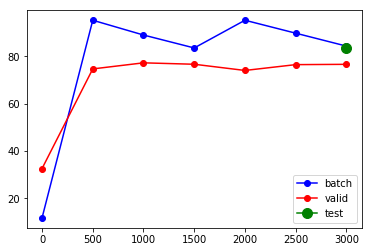

In [58]:
# ----------- Graph -------------
batch_size = 128

l2_coef = 0.1

num_node_h1 = 1014

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_h1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_node_h1])
  )
  biases_h1 = tf.Variable(tf.zeros([num_node_h1]))
        
  weights = tf.Variable(
    tf.truncated_normal([num_node_h1, num_labels])
  )
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  output_h1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_h1) + biases_h1)
    
  logits = tf.matmul(output_h1, weights) + biases

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
  ) + l2_coef * (
      tf.nn.l2_loss(weights_h1) + tf.nn.l2_loss(weights)
  )
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.relu(tf.matmul(tf_valid_dataset, weights_h1) + biases_h1),
        weights
    ) + biases
  )
  test_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.relu(tf.matmul(tf_test_dataset, weights_h1) + biases_h1),
        weights
    ) + biases
  )
    
    

# ----------- Session -------------    
start_time = time.time()

steps = []
batch_accus = []
valid_accus = []

test_steps = []
test_accus = []

num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized. 
    # So samples in each batch is equalivently randomly selected.
    # Note: we could use better randomization across epochs.
    
#     offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # restrict training data to small batches
    offset = (step * batch_size) % (3 * batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], 
      feed_dict=feed_dict
    )
    
    if (step % 500 == 0):
        steps.append(step)
        
        batch_accu = accuracy(predictions, batch_labels)
        batch_accus.append(batch_accu)        
        valid_accu = accuracy(valid_prediction.eval(), valid_labels)        
        valid_accus.append(valid_accu)
        
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % batch_accu)
        print("Validation accuracy: %.1f%%" % valid_accu)

  test_steps.append(step)
  test_accu = accuracy(test_prediction.eval(), test_labels)
  test_accus.append(test_accu)
  print("Test accuracy: %.1f%%" % test_accu)
    
print('\nrunning_time', time.time() - start_time, ' sec')

plt.figure()
plt.plot(steps, batch_accus, '-ob', label='batch')
plt.plot(steps, valid_accus, '-or', label='valid')
plt.plot(test_steps, test_accus, '-og', markersize=10, label='test')
plt.legend()
plt.show()    

---
Problem 3: Dropout
---------

Only during TRAINING (not evaluation), dropout on some of the actions of each layer, your network can never rely on any given activations to be present, so force NN to learn redundant representations. 
* It makes things more robust, and prevents overfitting.
* It also makes networks to act as if taking the consensus over an ensemble of networks, which is always a good way to improve performance. 
* Dropout is often very effective at reducing overfitting, and it is most useful when training very large neural networks.
---

Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [74]:
w_arr = np.array([
    range(10),
    range(10),
    range(10),    
])
print(w_arr)

w = tf.constant(w_arr, dtype=tf.float32)
print(w)

w_dropout = tf.nn.dropout(w, 0.5)

with tf.Session() as session:
    print(w.eval())
    print(w_dropout.eval())

[[0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]]
Tensor("Const_7:0", shape=(3, 10), dtype=float32)
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]]
[[  0.   2.   4.   6.   0.   0.  12.  14.  16.  18.]
 [  0.   0.   0.   0.   8.   0.   0.   0.   0.  18.]
 [  0.   2.   0.   0.   8.   0.  12.   0.  16.  18.]]


In [84]:
print(np.sum(w_arr, axis=1))
print(2 + 4 + 6 + 12 + 14 + 16 + 18)
print(8 + 18)
print(2 + 8 + 12 + 16 + 18)
print( (72 + 26 + 56) / 3.0)

[45 45 45]
72
26
56
51.3333333333


#### 1-Hidden NN, SGD, without L2 Regularization, without Dropout, all batch
Minibatch loss at step 3000: 2.139399
Minibatch accuracy: 86.7%
Validation accuracy: 82.2%
Test accuracy: 89.1%

#### 1-Hidden NN, SGD, with L2 Regularization, without Dropout, all batch
Minibatch accuracy: 88.3%
Validation accuracy: 86.9%
Test accuracy: 93.1%

#### 1-Hidden NN, SGD, without L2 Regularization, with Dropout, all batch

Initialized
Minibatch loss at step 0: 411.416321
Minibatch accuracy: 3.9%
Validation accuracy: 31.0%
Minibatch loss at step 500: 20.482780
Minibatch accuracy: 80.5%
Validation accuracy: 79.6%
Minibatch loss at step 1000: 6.809467
Minibatch accuracy: 77.3%
Validation accuracy: 81.2%
Minibatch loss at step 1500: 8.743010
Minibatch accuracy: 87.5%
Validation accuracy: 81.2%
Minibatch loss at step 2000: 3.041743
Minibatch accuracy: 80.5%
Validation accuracy: 81.0%
Minibatch loss at step 2500: 4.649157
Minibatch accuracy: 83.6%
Validation accuracy: 81.7%
Minibatch loss at step 3000: 2.333835
Minibatch accuracy: 78.9%
Validation accuracy: 81.9%
Test accuracy: 89.6%

running_time 74.9220209122  sec


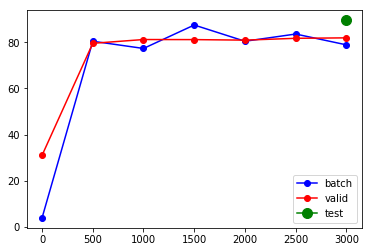

In [92]:
# ----------- Graph -------------
batch_size = 128

l2_coef = 0.0

num_node_h1 = 1014


# https://www.tensorflow.org/get_started/mnist/pros

# keep_prob = 0.2
#     Minibatch loss at step 3000: 14.334963
#     Minibatch accuracy: 44.5%
#     Validation accuracy: 58.6%
#     Test accuracy: 64.3%
    
# keep_prob = 0.5
#     Minibatch loss at step 3000: 4.258833
#     Minibatch accuracy: 74.2%
#     Validation accuracy: 79.9%
#     Test accuracy: 87.4%

# keep_prob = 0.8
#     Minibatch loss at step 3000: 2.636505
#     Minibatch accuracy: 82.8%
#     Validation accuracy: 81.9%
#     Test accuracy: 89.4%

keep_prob = 0.9
#     Minibatch loss at step 3000: 2.333835
#     Minibatch accuracy: 78.9%
#     Validation accuracy: 81.9%
#     Test accuracy: 89.6%

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_h1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_node_h1])
  )
  biases_h1 = tf.Variable(tf.zeros([num_node_h1]))
  output_h1 = tf.nn.dropout(
      tf.nn.relu(tf.matmul(tf_train_dataset, weights_h1) + biases_h1),
      keep_prob
  )

  weights = tf.Variable(
    tf.truncated_normal([num_node_h1, num_labels])
  )
  biases = tf.Variable(tf.zeros([num_labels]))
  logits = tf.matmul(output_h1, weights) + biases
    
  # Training computation.
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
  ) + l2_coef * (
      tf.nn.l2_loss(weights_h1) + tf.nn.l2_loss(weights)
  )
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.dropout(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_h1) + biases_h1), 1.0), 
        weights
    ) + biases
  )
  test_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_dataset, weights_h1) + biases_h1), 1.0), 
        weights
    ) + biases
  )
    
    

# ----------- Session -------------    
start_time = time.time()

steps = []
batch_accus = []
valid_accus = []

test_steps = []
test_accus = []

num_steps = 3001


# restrict training data to small batches
# batch_count = 3


with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized. 
    # So samples in each batch is equalivently randomly selected.
    # Note: we could use better randomization across epochs.
    
    
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
#     offset = (step * batch_size) % (batch_count * batch_size)

    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], 
      feed_dict=feed_dict
    )
    
    if (step % 500 == 0):
        steps.append(step)
        
        batch_accu = accuracy(predictions, batch_labels)
        batch_accus.append(batch_accu)        
        valid_accu = accuracy(valid_prediction.eval(), valid_labels)        
        valid_accus.append(valid_accu)
        
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % batch_accu)
        print("Validation accuracy: %.1f%%" % valid_accu)

  test_steps.append(step)
  test_accu = accuracy(test_prediction.eval(), test_labels)
  test_accus.append(test_accu)
  print("Test accuracy: %.1f%%" % test_accu)
    
print('\nrunning_time', time.time() - start_time, ' sec')

plt.figure()
plt.plot(steps, batch_accus, '-ob', label='batch')
plt.plot(steps, valid_accus, '-or', label='valid')
plt.plot(test_steps, test_accus, '-og', markersize=10, label='test')
plt.legend()
plt.show()    

#### 1-Hidden NN, SGD, without L2 Regularization, with Dropout, 3 batch

Initialized
Minibatch loss at step 0: 390.468536
Minibatch accuracy: 11.7%
Validation accuracy: 28.0%
Minibatch loss at step 500: 21.890957
Minibatch accuracy: 81.2%
Validation accuracy: 79.1%
Minibatch loss at step 1000: 14.556253
Minibatch accuracy: 76.6%
Validation accuracy: 80.2%
Minibatch loss at step 1500: 9.112808
Minibatch accuracy: 83.6%
Validation accuracy: 79.6%
Minibatch loss at step 2000: 3.979645
Minibatch accuracy: 82.8%
Validation accuracy: 81.2%
Minibatch loss at step 2500: 4.552000
Minibatch accuracy: 80.5%
Validation accuracy: 81.2%
Minibatch loss at step 3000: 2.268497
Minibatch accuracy: 78.1%
Validation accuracy: 81.2%
Test accuracy: 88.6%

running_time 78.4627099037  sec


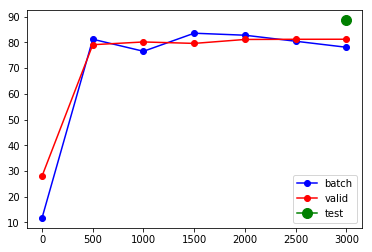

In [95]:
# ----------- Graph -------------
batch_size = 128

l2_coef = 0.0

num_node_h1 = 1014


# https://www.tensorflow.org/get_started/mnist/pros


# keep_prob = 0.1
#     Minibatch loss at step 3000: 40722422038528.000000
#     Minibatch accuracy: 63.3%
#     Validation accuracy: 73.4%
#     Test accuracy: 80.9%

keep_prob = 0.3
#     Minibatch accuracy: 100.0%
#     Validation accuracy: 77.9%
#     Test accuracy: 85.8%

# keep_prob = 0.7
#     Minibatch accuracy: 100.0%
#     Validation accuracy: 76.3%
#     Test accuracy: 84.5%

# keep_prob = 0.9
#     Minibatch loss at step 3000: 0.000000
#     Minibatch accuracy: 100.0%
#     Validation accuracy: 75.6%
#     Test accuracy: 83.2%


graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_h1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_node_h1])
  )
  biases_h1 = tf.Variable(tf.zeros([num_node_h1]))
  output_h1 = tf.nn.dropout(
      tf.nn.relu(tf.matmul(tf_train_dataset, weights_h1) + biases_h1),
      keep_prob
  )

  weights = tf.Variable(
    tf.truncated_normal([num_node_h1, num_labels])
  )
  biases = tf.Variable(tf.zeros([num_labels]))
  logits = tf.matmul(output_h1, weights) + biases
    
  # Training computation.
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
  ) + l2_coef * (
      tf.nn.l2_loss(weights_h1) + tf.nn.l2_loss(weights)
  )
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.dropout(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_h1) + biases_h1), 1.0), 
        weights
    ) + biases
  )
  test_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_dataset, weights_h1) + biases_h1), 1.0), 
        weights
    ) + biases
  )
    
    

# ----------- Session -------------    
start_time = time.time()

steps = []
batch_accus = []
valid_accus = []

test_steps = []
test_accus = []

num_steps = 3001

# restrict training data to small batches
batch_count = 3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized. 
    # So samples in each batch is equalivently randomly selected.
    # Note: we could use better randomization across epochs.
    
    
#     offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = (step * batch_size) % (batch_count * batch_size)

    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], 
      feed_dict=feed_dict
    )
    
    if (step % 500 == 0):
        steps.append(step)
        
        batch_accu = accuracy(predictions, batch_labels)
        batch_accus.append(batch_accu)        
        valid_accu = accuracy(valid_prediction.eval(), valid_labels)        
        valid_accus.append(valid_accu)
        
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % batch_accu)
        print("Validation accuracy: %.1f%%" % valid_accu)

  test_steps.append(step)
  test_accu = accuracy(test_prediction.eval(), test_labels)
  test_accus.append(test_accu)
  print("Test accuracy: %.1f%%" % test_accu)
    
print('\nrunning_time', time.time() - start_time, ' sec')

plt.figure()
plt.plot(steps, batch_accus, '-ob', label='batch')
plt.plot(steps, valid_accus, '-or', label='valid')
plt.plot(test_steps, test_accus, '-og', markersize=10, label='test')
plt.legend()
plt.show()    

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


#### 2-Hidden NN, SGD, with L2 Regularization, without Dropout, all batch

Initialized
Minibatch loss at step 0: 236.090393
Minibatch accuracy: 7.8%
Validation accuracy: 13.2%
Minibatch loss at step 500: 35.205997
Minibatch accuracy: 69.5%
Validation accuracy: 63.1%
Minibatch loss at step 1000: 13.401384
Minibatch accuracy: 75.8%
Validation accuracy: 76.5%
Minibatch loss at step 1500: 5.188563
Minibatch accuracy: 82.8%
Validation accuracy: 80.1%
Minibatch loss at step 2000: 2.305325
Minibatch accuracy: 89.1%
Validation accuracy: 81.9%
Minibatch loss at step 2500: 1.394821
Minibatch accuracy: 83.6%
Validation accuracy: 82.8%
Minibatch loss at step 3000: 1.014682
Minibatch accuracy: 82.8%
Validation accuracy: 83.5%
Minibatch loss at step 3500: 0.845412
Minibatch accuracy: 84.4%
Validation accuracy: 83.8%
Minibatch loss at step 4000: 0.712997
Minibatch accuracy: 85.9%
Validation accuracy: 83.8%
Minibatch loss at step 4500: 0.743252
Minibatch accuracy: 85.9%
Validation accuracy: 84.0%
Minibatch loss at step 5000: 0.682322
Minibatch accuracy: 85.9%
Validation accu

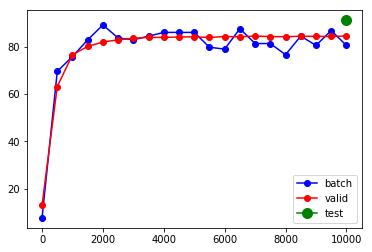

In [138]:
# ----------- Graph -------------
batch_size = 128

    
# num_node_h1 = 10
# num_node_h2 = 10
#     Minibatch loss at step 3000: 1.614468
#     Minibatch accuracy: 37.5%
#     Validation accuracy: 40.5%
#     Test accuracy: 44.2%

#     Minibatch loss at step 6000: 1.599897
#     Minibatch accuracy: 39.8%
#     Validation accuracy: 43.5%
#     Test accuracy: 47.1%
    
#     Minibatch loss at step 10000: 1.553808
#     Minibatch accuracy: 48.4%
#     Validation accuracy: 47.8%
#     Test accuracy: 51.5%

# num_node_h1 = 20
# num_node_h2 = 20
#     Minibatch loss at step 9500: 0.759732
#     Minibatch accuracy: 84.4%
#     Validation accuracy: 83.6%
#     Minibatch loss at step 10000: 0.813377
#     Minibatch accuracy: 78.9%
#     Validation accuracy: 83.8%
#     Test accuracy: 90.6%


num_node_h1 = 30
num_node_h2 = 30
# l2_coef = 0.0
#     Minibatch loss at step 3000: 2.300879
#     Minibatch accuracy: 10.2%
#     Validation accuracy: 10.0%
#     Test accuracy: 10.0%

#     Minibatch loss at step 10000: 0.776604
#     Minibatch accuracy: 79.7%
#     Validation accuracy: 84.1%
#     Test accuracy: 91.0%


# num_node_h1 = 50
# num_node_h2 = 50
# l2_coef = 0.0
#     Minibatch loss at step 3000: 2.300879
#     Minibatch accuracy: 10.2%
#     Validation accuracy: 10.0%
#     Test accuracy: 10.0%

# l2_coef = 0.01
#     Minibatch loss at step 10000: 0.935666
#     Minibatch accuracy: 78.9%
#     Validation accuracy: 82.1%
#     Test accuracy: 88.7%


# num_node_h1 = 100
# num_node_h2 = 100
# learning_rate = 0.1
#     Minibatch loss at step 10000: 0.783008
#     Minibatch accuracy: 80.5%
#     Validation accuracy: 84.4%
#     Test accuracy: 91.4%

# learning_rate = 0.5
#     loss is nan
    

# num_node_h1 = 1014
# num_node_h2 = 10
#     loss is nan

# num_node_h1 = 1014
# num_node_h2 = 1014
#     loss is nan



# l2_coef = 0.0
#     Minibatch loss at step 15500: 0.821611
#     Minibatch accuracy: 74.2%
#     Validation accuracy: 79.7%
#     Minibatch loss at step 16000: 0.596742
#     Minibatch accuracy: 84.4%
#     Validation accuracy: 79.5%
#     Test accuracy: 87.3%

# l2_coef = 0.01
#     Minibatch loss at step 9500: 0.794812
#     Minibatch accuracy: 83.6%
#     Validation accuracy: 83.0%
#     Minibatch loss at step 10000: 0.817868
#     Minibatch accuracy: 77.3%
#     Validation accuracy: 83.2%
#     Test accuracy: 89.8%

l2_coef = 0.01
#     Minibatch loss at step 9500: 1.186753
#     Minibatch accuracy: 80.5%
#     Validation accuracy: 80.5%
#     Minibatch loss at step 10000: 1.052360
#     Minibatch accuracy: 79.7%
#     Validation accuracy: 81.1%
#     Test accuracy: 88.4%



keep_prob = 1.0

# keep_prob = 0.8
#     Minibatch loss at step 10000: 1.557589
#     Minibatch accuracy: 48.4%
#     Validation accuracy: 71.8%
#     Test accuracy: 79.2%


learning_rate = 0.1
#     Minibatch loss at step 15500: 0.821611
#     Minibatch accuracy: 74.2%
#     Validation accuracy: 79.7%
#     Minibatch loss at step 16000: 0.596742
#     Minibatch accuracy: 84.4%
#     Validation accuracy: 79.5%
#     Test accuracy: 87.3%


# learning_rate = 0.5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_h1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_node_h1])
  )
  biases_h1 = tf.Variable(tf.zeros([num_node_h1]))
  output_h1 = tf.nn.dropout(
      tf.nn.relu(tf.matmul(tf_train_dataset, weights_h1) + biases_h1),
      keep_prob
  )


  weights_h2 = tf.Variable(
    tf.truncated_normal([num_node_h1, num_node_h2])
  )
  biases_h2 = tf.Variable(tf.zeros([num_node_h2]))
  output_h2 = tf.nn.dropout(
      tf.nn.relu(tf.matmul(output_h1, weights_h2) + biases_h2),
      keep_prob
  )

    
  weights = tf.Variable(
    tf.truncated_normal([num_node_h2, num_labels])
  )
  biases = tf.Variable(tf.zeros([num_labels]))
  logits = tf.matmul(output_h2, weights) + biases
    
  # Training computation.
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
  ) + l2_coef * (
      tf.nn.l2_loss(weights_h1) + tf.nn.l2_loss(weights_h2) + tf.nn.l2_loss(weights)
  )
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
#   optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.dropout(tf.nn.relu(tf.matmul(
            tf.nn.dropout(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_h1) + biases_h1), 1.0), 
            weights_h2
        ) + biases_h2), 1.0),         
        weights
    ) + biases
  )
  test_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.dropout(tf.nn.relu(tf.matmul(
            tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_dataset, weights_h1) + biases_h1), 1.0), 
            weights_h2
        ) + biases_h2), 1.0),         
        weights
    ) + biases
  )
    
    

# ----------- Session -------------    
start_time = time.time()

steps = []
batch_accus = []
valid_accus = []

test_steps = []
test_accus = []

# num_steps = 3001
num_steps = 10001


# restrict training data to small batches
# batch_count = 3


with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized. 
    # So samples in each batch is equalivently randomly selected.
    # Note: we could use better randomization across epochs.
    
    
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
#     offset = (step * batch_size) % (batch_count * batch_size)

    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], 
      feed_dict=feed_dict
    )
    
    if (step % 500 == 0):
        steps.append(step)
        
        batch_accu = accuracy(predictions, batch_labels)
        batch_accus.append(batch_accu)        
        valid_accu = accuracy(valid_prediction.eval(), valid_labels)        
        valid_accus.append(valid_accu)
        
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % batch_accu)
        print("Validation accuracy: %.1f%%" % valid_accu)

  test_steps.append(step)
  test_accu = accuracy(test_prediction.eval(), test_labels)
  test_accus.append(test_accu)
  print("Test accuracy: %.1f%%" % test_accu)
    
print('\nrunning_time', time.time() - start_time, ' sec')

plt.figure()
plt.plot(steps, batch_accus, '-ob', label='batch')
plt.plot(steps, valid_accus, '-or', label='valid')
plt.plot(test_steps, test_accus, '-og', markersize=10, label='test')
plt.legend()
plt.show()    

#### 1-Hidden NN, SGD, without L2 Regularization, without Dropout, all batch, decay learning_rate

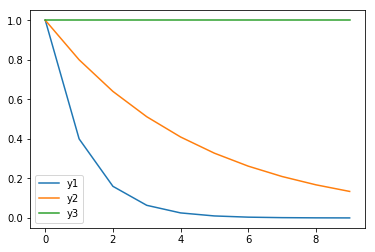

In [161]:
x = np.array(range(0, 10, 1))

b1 = 0.4
b2 = 0.8
b3 = 1
b4 = 2

y1 = np.power(b1, x)
y2 = np.power(b2, x)
y3 = np.power(b3, x)
y4 = np.power(b4, x)
# print(y1)
# print(y2)

plt.plot(x, y1, label='y1')
plt.plot(x, y2, label='y2')
plt.plot(x, y3, label='y3')
# plt.plot(x, y4, label='y4')
plt.legend()
plt.show()

Initialized
global_step 1 learning_rate 0.499888
Minibatch loss at step 0: 333.577179
Minibatch accuracy: 5.5%
Validation accuracy: 24.8%
global_step 501 learning_rate 0.447114
Minibatch loss at step 500: 14.202440
Minibatch accuracy: 85.2%
Validation accuracy: 79.5%
global_step 1001 learning_rate 0.399911
Minibatch loss at step 1000: 11.439359
Minibatch accuracy: 78.1%
Validation accuracy: 80.7%
global_step 1501 learning_rate 0.357691
Minibatch loss at step 1500: 4.761704
Minibatch accuracy: 86.7%
Validation accuracy: 80.2%
global_step 2001 learning_rate 0.319929
Minibatch loss at step 2000: 1.717274
Minibatch accuracy: 89.1%
Validation accuracy: 82.8%
global_step 2501 learning_rate 0.286153
Minibatch loss at step 2500: 2.507278
Minibatch accuracy: 82.8%
Validation accuracy: 82.4%
global_step 3001 learning_rate 0.255943
Minibatch loss at step 3000: 1.218851
Minibatch accuracy: 86.7%
Validation accuracy: 83.3%
Test accuracy: 90.7%

running_time 86.7855420113  sec


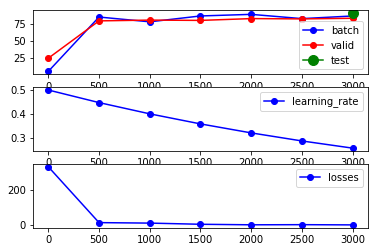

In [166]:
# ----------- Graph -------------
batch_size = 128

l2_coef = 0.0

num_node_h1 = 1014

keep_prob = 1.0


graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_h1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_node_h1])
  )
  biases_h1 = tf.Variable(tf.zeros([num_node_h1]))
  output_h1 = tf.nn.dropout(
      tf.nn.relu(tf.matmul(tf_train_dataset, weights_h1) + biases_h1),
      keep_prob
  )

  weights = tf.Variable(
    tf.truncated_normal([num_node_h1, num_labels])
  )
  biases = tf.Variable(tf.zeros([num_labels]))
  logits = tf.matmul(output_h1, weights) + biases
    
  # Training computation.
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
  ) + l2_coef * (
      tf.nn.l2_loss(weights_h1) + tf.nn.l2_loss(weights)
  )
  
  # Optimizer. 
  global_step = tf.Variable(0, trainable=False)  # count the number of steps taken
  starter_learning_rate = 0.5
  decay_steps = 1000
  decay_rate = 0.8
  learning_rate = tf.train.exponential_decay(
      starter_learning_rate, 
      global_step, 
      decay_steps,
      decay_rate,
      staircase=False
  )
    
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
      loss, 
      global_step=global_step
  )
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.dropout(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_h1) + biases_h1), 1.0), 
        weights
    ) + biases
  )
  test_prediction = tf.nn.softmax(
    tf.matmul(
        tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_dataset, weights_h1) + biases_h1), 1.0), 
        weights
    ) + biases
  )
    
    

# ----------- Session -------------    
start_time = time.time()

steps = []
batch_accus = []
valid_accus = []

test_steps = []
test_accus = []

learning_rates = []

losses = []


num_steps = 3001


# restrict training data to small batches
# batch_count = 3


with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized. 
    # So samples in each batch is equalivently randomly selected.
    # Note: we could use better randomization across epochs.
    
    
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
#     offset = (step * batch_size) % (batch_count * batch_size)

    
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], 
      feed_dict=feed_dict
    )
    
    if (step % 500 == 0):
        steps.append(step)
        
        batch_accu = accuracy(predictions, batch_labels)
        batch_accus.append(batch_accu)        
        valid_accu = accuracy(valid_prediction.eval(), valid_labels)        
        valid_accus.append(valid_accu)
        
        current_learning_rate = learning_rate.eval()
        learning_rates.append(current_learning_rate)
        
        losses.append(l)
        
        print('global_step', global_step.eval(), 'learning_rate', current_learning_rate)
        print("Minibatch loss at step %d: %f" % (step, l))
        print("Minibatch accuracy: %.1f%%" % batch_accu)
        print("Validation accuracy: %.1f%%" % valid_accu)

  test_steps.append(step)
  test_accu = accuracy(test_prediction.eval(), test_labels)
  test_accus.append(test_accu)
  print("Test accuracy: %.1f%%" % test_accu)
    
print('\nrunning_time', time.time() - start_time, ' sec')

plt.figure()

plt.subplot(3, 1, 1)
plt.plot(steps, batch_accus, '-ob', label='batch')
plt.plot(steps, valid_accus, '-or', label='valid')
plt.plot(test_steps, test_accus, '-og', markersize=10, label='test')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(steps, learning_rates, '-ob', label='learning_rate')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(steps, losses, '-ob', label='losses')
plt.legend()

plt.show()  

#### 2-Hidden NN, SGD, without L2 Regularization, without Dropout, all batch, decay learning_rate

Initialized
global_step 1 learning_rate 0.499888
Minibatch loss at step 0: 201.714935
Minibatch accuracy: 13.3%
Validation accuracy: 19.2%
global_step 501 learning_rate 0.447114
Minibatch loss at step 500: 2.287638
Minibatch accuracy: 7.8%
Validation accuracy: 14.3%
global_step 1001 learning_rate 0.399911
Minibatch loss at step 1000: 2.144354
Minibatch accuracy: 17.2%
Validation accuracy: 16.4%
global_step 1501 learning_rate 0.357691
Minibatch loss at step 1500: 2.218470
Minibatch accuracy: 15.6%
Validation accuracy: 17.4%
global_step 2001 learning_rate 0.319929
Minibatch loss at step 2000: 2.073119
Minibatch accuracy: 18.0%
Validation accuracy: 19.6%
global_step 2501 learning_rate 0.286153
Minibatch loss at step 2500: 2.110337
Minibatch accuracy: 19.5%
Validation accuracy: 22.6%
global_step 3001 learning_rate 0.255943
Minibatch loss at step 3000: 2.023086
Minibatch accuracy: 21.9%
Validation accuracy: 23.6%
global_step 3501 learning_rate 0.228922
Minibatch loss at step 3500: 2.030205


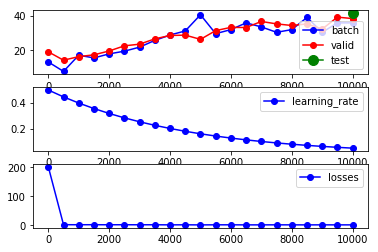

In [176]:
# ----------- Graph -------------
batch_size = 128

# num_steps = 3001
num_steps = 10001

num_node_h1 = 30
num_node_h2 = 30
l2_coef = 0.0
keep_prob = 1.0
#     global_step 10001 learning_rate 0.0536751
#     Minibatch loss at step 10000: 1.691663
#     Minibatch accuracy: 35.9%
#     Validation accuracy: 38.4%
#     Test accuracy: 41.5%

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    # h1
    weights_h1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_node_h1])
    )
    biases_h1 = tf.Variable(tf.zeros([num_node_h1]))
    output_h1 = tf.nn.dropout(
        tf.nn.relu(tf.matmul(tf_train_dataset, weights_h1) + biases_h1),
        keep_prob
    )

    # h2
    weights_h2 = tf.Variable(
        tf.truncated_normal([num_node_h1, num_node_h2])
    )
    biases_h2 = tf.Variable(tf.zeros([num_node_h2]))
    output_h2 = tf.nn.dropout(
        tf.nn.relu(tf.matmul(output_h1, weights_h2) + biases_h2),
        keep_prob
    )

    # output layer
    weights = tf.Variable(
        tf.truncated_normal([num_node_h2, num_labels])
    )
    biases = tf.Variable(tf.zeros([num_labels]))
    logits = tf.matmul(output_h2, weights) + biases

    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    ) + l2_coef * (
        tf.nn.l2_loss(weights_h1) + tf.nn.l2_loss(weights_h2) + tf.nn.l2_loss(weights)
    )

    # Optimizer.
    #   optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)

    global_step = tf.Variable(0, trainable=False)  # count the number of steps taken
    starter_learning_rate = 0.5
    decay_steps = 1000
    decay_rate = 0.8
    learning_rate = tf.train.exponential_decay(
        starter_learning_rate, 
        global_step, 
        decay_steps,
        decay_rate,
        staircase=False
    )

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss, 
        global_step=global_step
    )


    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(
            tf.nn.dropout(tf.nn.relu(tf.matmul(
                tf.nn.dropout(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_h1) + biases_h1), 1.0), 
                weights_h2
            ) + biases_h2), 1.0),         
            weights
        ) + biases
    )
    test_prediction = tf.nn.softmax(
        tf.matmul(
            tf.nn.dropout(tf.nn.relu(tf.matmul(
                tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_dataset, weights_h1) + biases_h1), 1.0), 
                weights_h2
            ) + biases_h2), 1.0),         
            weights
        ) + biases
    )



# ----------- Session -------------    
start_time = time.time()

steps = []
batch_accus = []
valid_accus = []

test_steps = []
test_accus = []

learning_rates = []

losses = []


# restrict training data to small batches
# batch_count = 3


with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized. 
        # So samples in each batch is equalivently randomly selected.
        # Note: we could use better randomization across epochs.


        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        #     offset = (step * batch_size) % (batch_count * batch_size)


        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}

        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], 
          feed_dict=feed_dict
        )

        if (step % 500 == 0):
            steps.append(step)

            batch_accu = accuracy(predictions, batch_labels)
            batch_accus.append(batch_accu)        
            valid_accu = accuracy(valid_prediction.eval(), valid_labels)        
            valid_accus.append(valid_accu)

            current_learning_rate = learning_rate.eval()
            learning_rates.append(current_learning_rate)

            losses.append(l)

            print('global_step', global_step.eval(), 'learning_rate', current_learning_rate)
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % batch_accu)
            print("Validation accuracy: %.1f%%" % valid_accu)

    test_steps.append(step)
    test_accu = accuracy(test_prediction.eval(), test_labels)
    test_accus.append(test_accu)
    print("Test accuracy: %.1f%%" % test_accu)

print('\nrunning_time', time.time() - start_time, ' sec')


plt.figure()

plt.subplot(3, 1, 1)
plt.plot(steps, batch_accus, '-ob', label='batch')
plt.plot(steps, valid_accus, '-or', label='valid')
plt.plot(test_steps, test_accus, '-og', markersize=10, label='test')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(steps, learning_rates, '-ob', label='learning_rate')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(steps, losses, '-ob', label='losses')
plt.legend()

plt.show()  

#### 2-Hidden NN, SGD, with L2 Regularization, without Dropout, all batch, decay learning_rate

Initialized
global_step 1 learning_rate 0.0999777
Minibatch loss at step 0: 296.316528
Minibatch accuracy: 8.6%
Validation accuracy: 10.0%
global_step 501 learning_rate 0.0894228
Minibatch loss at step 500: 38.290154
Minibatch accuracy: 46.1%
Validation accuracy: 50.6%
global_step 1001 learning_rate 0.0799822
Minibatch loss at step 1000: 16.640381
Minibatch accuracy: 71.9%
Validation accuracy: 74.3%
global_step 1501 learning_rate 0.0715382
Minibatch loss at step 1500: 7.932991
Minibatch accuracy: 85.2%
Validation accuracy: 78.6%
global_step 2001 learning_rate 0.0639857
Minibatch loss at step 2000: 4.361058
Minibatch accuracy: 88.3%
Validation accuracy: 80.6%
global_step 2501 learning_rate 0.0572306
Minibatch loss at step 2500: 2.803824
Minibatch accuracy: 79.7%
Validation accuracy: 81.6%
global_step 3001 learning_rate 0.0511886
Minibatch loss at step 3000: 1.934478
Minibatch accuracy: 82.8%
Validation accuracy: 82.2%
global_step 3501 learning_rate 0.0457845
Minibatch loss at step 3500:

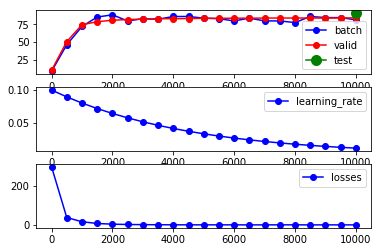

In [180]:
# ----------- Graph -------------
batch_size = 128

# num_steps = 3001
num_steps = 10001

num_node_h1 = 30
num_node_h2 = 30
l2_coef = 0.01
keep_prob = 1.0
starter_learning_rate = 0.1
decay_steps = 1000
decay_rate = 0.8
#     global_step 10001 learning_rate 0.0536751
#     Minibatch loss at step 10000: 0.794600
#     Minibatch accuracy: 82.8%
#     Validation accuracy: 84.5%
#     Test accuracy: 90.9%

# num_node_h1 = 100
# num_node_h2 = 100
# l2_coef = 0.01
# keep_prob = 1.0
# starter_learning_rate = 0.5
# decay_steps = 1000
# decay_rate = 0.8
#     loss nan

# num_node_h1 = 100
# num_node_h2 = 100
# l2_coef = 0.01
# keep_prob = 1.0
# starter_learning_rate = 0.1
# decay_steps = 1000
# decay_rate = 0.8
#     global_step 10001 learning_rate 0.010735
#     Minibatch loss at step 10000: 0.869751
#     Minibatch accuracy: 80.5%
#     Validation accuracy: 84.4%
#     Test accuracy: 90.9%


graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    # h1
    weights_h1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_node_h1])
    )
    biases_h1 = tf.Variable(tf.zeros([num_node_h1]))
    output_h1 = tf.nn.dropout(
        tf.nn.relu(tf.matmul(tf_train_dataset, weights_h1) + biases_h1),
        keep_prob
    )

    # h2
    weights_h2 = tf.Variable(
        tf.truncated_normal([num_node_h1, num_node_h2])
    )
    biases_h2 = tf.Variable(tf.zeros([num_node_h2]))
    output_h2 = tf.nn.dropout(
        tf.nn.relu(tf.matmul(output_h1, weights_h2) + biases_h2),
        keep_prob
    )

    # output layer
    weights = tf.Variable(
        tf.truncated_normal([num_node_h2, num_labels])
    )
    biases = tf.Variable(tf.zeros([num_labels]))
    logits = tf.matmul(output_h2, weights) + biases

    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    ) + l2_coef * (
        tf.nn.l2_loss(weights_h1) + tf.nn.l2_loss(weights_h2) + tf.nn.l2_loss(weights)
    )

    # Optimizer.
    #   optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)

    global_step = tf.Variable(0, trainable=False)  # count the number of steps taken
    learning_rate = tf.train.exponential_decay(
        starter_learning_rate, 
        global_step, 
        decay_steps,
        decay_rate,
        staircase=False
    )

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss, 
        global_step=global_step
    )


    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(
            tf.nn.dropout(tf.nn.relu(tf.matmul(
                tf.nn.dropout(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_h1) + biases_h1), 1.0), 
                weights_h2
            ) + biases_h2), 1.0),         
            weights
        ) + biases
    )
    test_prediction = tf.nn.softmax(
        tf.matmul(
            tf.nn.dropout(tf.nn.relu(tf.matmul(
                tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_dataset, weights_h1) + biases_h1), 1.0), 
                weights_h2
            ) + biases_h2), 1.0),         
            weights
        ) + biases
    )



# ----------- Session -------------    
start_time = time.time()

steps = []
batch_accus = []
valid_accus = []

test_steps = []
test_accus = []

learning_rates = []

losses = []


# restrict training data to small batches
# batch_count = 3


with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized. 
        # So samples in each batch is equalivently randomly selected.
        # Note: we could use better randomization across epochs.


        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        #     offset = (step * batch_size) % (batch_count * batch_size)


        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}

        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], 
          feed_dict=feed_dict
        )

        if (step % 500 == 0):
            steps.append(step)

            batch_accu = accuracy(predictions, batch_labels)
            batch_accus.append(batch_accu)        
            valid_accu = accuracy(valid_prediction.eval(), valid_labels)        
            valid_accus.append(valid_accu)

            current_learning_rate = learning_rate.eval()
            learning_rates.append(current_learning_rate)

            losses.append(l)

            print('global_step', global_step.eval(), 'learning_rate', current_learning_rate)
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % batch_accu)
            print("Validation accuracy: %.1f%%" % valid_accu)

    test_steps.append(step)
    test_accu = accuracy(test_prediction.eval(), test_labels)
    test_accus.append(test_accu)
    print("Test accuracy: %.1f%%" % test_accu)

print('\nrunning_time', time.time() - start_time, ' sec')


plt.figure()

plt.subplot(3, 1, 1)
plt.plot(steps, batch_accus, '-ob', label='batch')
plt.plot(steps, valid_accus, '-or', label='valid')
plt.plot(test_steps, test_accus, '-og', markersize=10, label='test')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(steps, learning_rates, '-ob', label='learning_rate')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(steps, losses, '-ob', label='losses')
plt.legend()

plt.show()  